In [1]:
import os
# os.sysjupyter nbextension enable --py --sys-prefix widgetsnbextension
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

# Cyclic Simple Shear (CSS) test using OpenSees and PM4Sand 

This notebook presents a single element geotechnical example using OpenSees3.2.0 and the PM4Sand constitutive model. 
Two tcl scripts are used to run undrained cyclic simple shear tests for selected material parameters and initial and loading conditions. 
Both scripts apply stress control test conditions. One uses nodal loads to control stresses and a coupled UP quad element (SSPquadUP) to impose undrained boundary conditions (DSS_quad_ForceControl.tcl). The other uses nodal displacements to enforce constant volume (undrained condition) and to impose stresses, and a single phase quad element (SSPquad) (DSS_quad_dispControl.tcl). The material properties are defined in terms of relative density (Dr), shear modulus constant (Go), and hardening parameter (Hpo). An automatic option is provided to automatically generate Go and hpo as a function of Dr. The initial condition is defined in terms of initial vertical effective stress (sigmav). The loading condition is defined in terms of cyclic stress ratio (csr). The cyclic test runs untils a single direction maximum shear strain (maxStrain) is reached.  

In [2]:
# Import python modules
import os,sys
import math
import numpy as np
from ipywidgets import *
from IPython.display import display
from IPython.display import Javascript
from subprocess import Popen
import multiprocessing

from CreatePlotsF import createPlotsF
from CreatePlotsD import createPlotsD

import warnings
import matplotlib
import matplotlib.cbook
#%matplotlib inline
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

runCell = 'FALSE'

In [3]:
model1Pic = os.path.join('./CSSschematic.png')

file1 = open(model1Pic, "rb")
image1 = file1.read()
CSSImage = widgets.Image(
        value=image1,
        format='png',
        width=700,
        height=350
)
display(CSSImage)

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x05\x95\x00\x00\x03*\x08\x06\x00\x00\x00\xfa\x81\xaf…

## Material Parameters (PM4Sand)

In [4]:
descriptionHTML = widgets.HTML(
        value="<b>PRIMARY PM4Sand MATERIAL PARAMETERS</b><br/> ",
        placeholder='',
        description='',    
)
display(descriptionHTML)

def on_Select(change):
        return
def radio_buttonSelected(b):
    
    if M4.value == 'manual':
        print('manual')
    elif M4.value == 'automatic':
        print('automatic')
        N160 = ((M1.value/100)**2)*46
        CRR  = min(0.6,np.exp(N160/14.1+(N160/126)**2-(N160/23.6)**3+(N160/25.4)**4-2.8))
        G01  = 167*math.sqrt(N160+2.5)
        M2.value = G01
    return
#    
# -----------------------------------------------------------------------------------------------------------------------
#
style = {'description_width': 'initial'}
FloatText(description='A too long description', style=style)        

M1 = widgets.FloatText(
    value=55,
    description='Dr [%] (Relative density):',
    style = style,
    layout=Layout(width='8cm', height='1cm'),
    disabled=False
)

M2 = widgets.FloatText(
    value=677,
    description='Go (Shear modulus parameter ):',
    style = style,
    layout=Layout(width='8cm', height='1cm'),
    disabled=False
)

M3 = widgets.FloatText(
    value=0.4,
    description='hpo (hardening parameter):',
    style = style,
    layout=Layout(width='8cm', height='1.5cm'),
    disabled=False
)

M4 = widgets.RadioButtons(
    options=['manual', 'automatic'],
    value='manual',
    description='Properties generation:',
    style = style,
    layout=Layout(width='8cm', height='1.5cm'),
    disabled=False
)

M = [M1, M2, M3, M4]
container1a = widgets.VBox(children=[M[0], M[1], M[2], M[3]])
display(container1a)
M4.observe(radio_buttonSelected)

HTML(value='<b>PRIMARY PM4Sand MATERIAL PARAMETERS</b><br/> ', placeholder='')

## Initial and loading conditions

In [5]:
descriptionHTML = widgets.HTML(
        value="<b>LOADING CONDITIONS</b><br/> ",
        placeholder='',
        description='',    
)
display(descriptionHTML)

def on_Select(change):
    return
def on_buttonClicked(b):
    
    global runCell
    runCell = 'TRUE'
    
    display(Javascript(\
    'IPython.notebook.execute_cell_range(\
     IPython.notebook.get_selected_index()+1,\
     IPython.notebook.get_selected_index()+3)'))
    #display(Javascript(\
    #    'IPython.notebook.execute_cell_range(\
    #     IPython.notebook.get_selected_index()+1,\
    #     IPython.notebook.ncells())'))
#    
# -----------------------------------------------------------------------------------------------------------------------
#
style = {'description_width': 'initial'}
FloatText(description='A too long description', style=style)        
    
L1 = widgets.FloatText(
    value=101.3,
    description='sigmaV (Initial vertical effective stress):',
    style = style,
    layout=Layout(width='8cm', height='1cm'),
    disabled=False
)

L2 = widgets.FloatText(
    value=0.14,
    description='CSR (Cyclic Stress Ratio):',
    style = style,
    layout=Layout(width='8cm', height='1cm'),
    disabled=False
)

L3 = widgets.FloatText(
    value=0.03,
    description='maxStrain (Max strain for liq.):',
    style = style,
    layout=Layout(width='8cm', height='1.5cm'),
    disabled=False
)

L4 = widgets.RadioButtons(
    options=['Displacement Control', 'Force Control'],
    value='Displacement Control', # Defaults to 'pineapple'
    description='OpenSees analysis type:',
    style = style,
    layout=Layout(width='8cm', height='1.5cm'),
    disabled=False
)

showButton = widgets.Button(
    description='Go',
    layout=Layout(width='8cm', height='1cm'),
    disabled=False,
    button_style='info', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
    icon='check'
)

L = [L1, L2, L3, L4]
container2a = widgets.VBox(children=[L[0], L[1], L[2], L[3]])
container2b = widgets.VBox(children = [container2a, showButton])
display(container2b)
showButton.on_click(on_buttonClicked)

HTML(value='<b>LOADING CONDITIONS</b><br/> ', placeholder='')

<IPython.core.display.Javascript object>

In [8]:
if runCell == 'TRUE':
    
    Dr        = float(M[0].value)/100; # Relative density
    G0        = float(M[1].value)
    hpo       = float(M[2].value)
    
    sigmav    = float(-L[0].value)
    csr       = float(L[1].value)
    maxStrain = float(L[2].value)
    
    if L4.value == 'Displacement Control':
        filename = 'DSS_quad_DispControl.tcl'
    else:
        filename = 'DSS_quad_ForceControl.tcl'
    
    err = open("log", "wb")
    if os.sys.platform == "win32":
        print('Running OpenSees (WIN32) ...')
        print(filename)
        command2Run = os.path.join('OpenSees '+filename+' {} {} {} {} {} {} ')
        p = Popen(command2Run .format(Dr, G0, hpo, sigmav, csr, maxStrain), stderr = err, shell = True)
        
    else:
        print('Running OpenSees (LINUX) ...')
        print(filename)
        # This is for wsl (must update location for your system)
        command2Run = os.path.join('/mnt/c/Tools/OpenSees/Win64/bin/OpenSees.exe '+filename+' {} {} {} {} {} {} ')
        p = Popen(command2Run .format(Dr, G0, hpo, sigmav, csr, maxStrain), stderr = err, shell = True)
        
    p.wait()
    print('Finished OpenSees ...')

Running OpenSees (WIN32) ...
DSS_quad_DispControl.tcl
Finished OpenSees ...


Creating plots ...


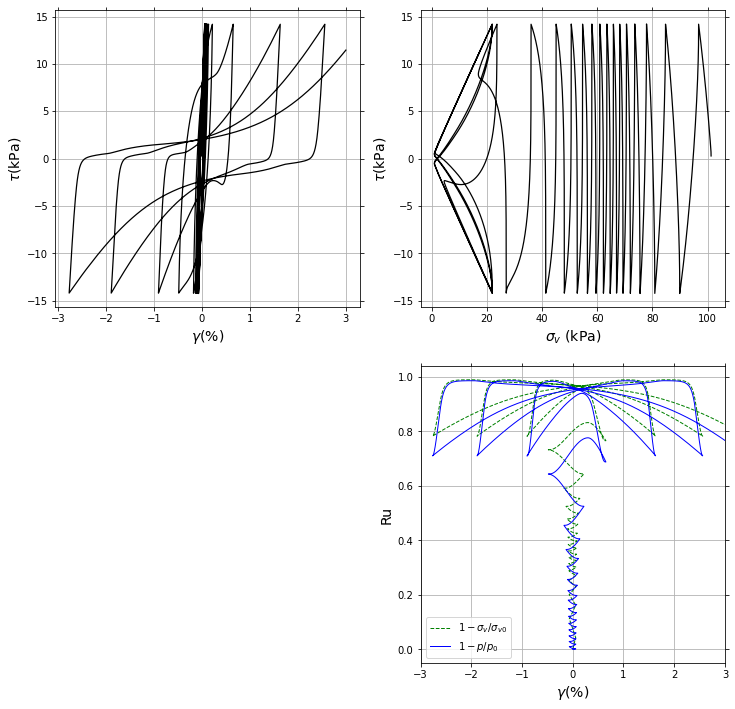

FINISHED


In [9]:
if runCell == 'TRUE':

    print('Creating plots ...')
    if L4.value == 'Displacement Control':
        createPlotsD()
    else:
        createPlotsF()
        
    print('FINISHED')
    plt.show()